In [1]:
!python.exe -m pip install --upgrade pip
!pip install pandas; numpy;  scikit-learn; seaborn; category_encoders; matplotlib;  xgboost  --quiet

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score,recall_score, f1_score
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import matplotlib as plt

In [2]:
#dataset
dfs = []
for i in range(1,5):
    path = './data/UNSW-NB_complet/UNSW-NB15_{}.csv'  
    dfs.append(pd.read_csv(path.format(i), header = None, low_memory=False))
df = pd.concat(dfs).reset_index(drop=True)

df_col = pd.read_csv('./data/UNSW-NB_complet/NUSW-NB15_features.csv', encoding='ISO-8859-1')
df_col['Name'] = df_col['Name'].apply(lambda x: x.strip().replace(' ', '').lower())

df.columns = df_col['Name']

cols_to_drop_total = [
    'srcip', 'dstip', 'stime', 'ltime',
    'dsport', 'sport',
    'attack_cat',
    'stcpb', 'dtcpb',
    'trans_depth', 'res_bdy_len',
    'is_ftp_login', 'ct_flw_http_mthd', 'ct_ftp_cmd',
    'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
    'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm'
]



df.drop(columns=cols_to_drop_total, inplace=True)

#eliminam duplicatele
df = df.drop_duplicates().reset_index(drop=True)
        
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

#verificam ca train si test sunt disjuncte
train_idx = df_train.index
test_idx = df_test.index
common_idx = train_idx.intersection(test_idx)
print(f'Intersectie dupa index: {len(common_idx)} randuri comune')



Intersectie dupa index: 0 randuri comune


In [3]:
malign_train = df_train[df_train['label'] == 1]
benign_train = df_train[df_train['label'] == 0]

n = min(len(malign_train), len(benign_train))

malign_train = resample(malign_train, 
                            replace=True, 
                            n_samples=n, 
                            random_state=42)
benign_train = resample(benign_train,
                            replace=True, 
                            n_samples=n, 
                            random_state=42)

df_train = pd.concat([malign_train, benign_train])
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)


malign_test = df_test[df_test['label'] == 1]
benign_test = df_test[df_test['label'] == 0]

n = min(len(malign_test), len(benign_test))

malign_test = resample(malign_test, 
                            replace=True, 
                            n_samples=n, 
                            random_state=42)
benign_test = resample(benign_test,
                            replace=True, 
                            n_samples=n, 
                            random_state=42)

df_test = pd.concat([malign_test, benign_test])
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)



In [4]:
transform_cols = [  'proto', 
                    'state',
                    'service'
                    ]

encoder = TargetEncoder(cols=transform_cols, handle_unknown='value')

df_train_encoded = encoder.fit_transform(df_train[transform_cols], df_train['label'])
df_train_rest = df_train.drop(columns=transform_cols)
df_train = pd.concat([df_train_rest, df_train_encoded], axis=1)

df_test_encoded = encoder.transform(df_test[transform_cols])
df_test_rest = df_test.drop(columns=transform_cols)
df_test = pd.concat([df_test_rest, df_test_encoded], axis=1)

In [5]:
X = df_train.drop(columns=['label'])
y = df_train['label']

giwrf = RandomForestClassifier(
    n_estimators=100,          
    class_weight='balanced',   
    random_state=42,
    n_jobs=-1               
)


giwrf.fit(X, y)

feature_importances = pd.Series(giwrf.feature_importances_, index=X.columns)


threshold = 0.02
selected_features_gini = feature_importances[feature_importances > threshold].index.tolist()

df_train = df_train[selected_features_gini + ['label']]
df_test = df_test[selected_features_gini + ['label']]


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     12003
           1       0.98      1.00      0.99     12003

    accuracy                           0.99     24006
   macro avg       0.99      0.99      0.99     24006
weighted avg       0.99      0.99      0.99     24006



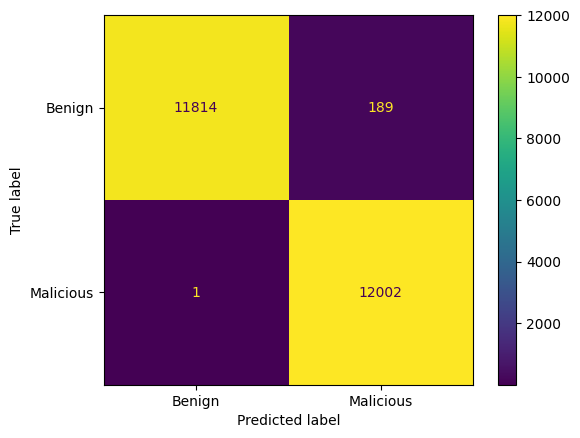

In [8]:
X_train = df_train.drop(columns=['label'])
y_train = df_train['label']
X_test = df_test.drop(columns=['label'])
y_test = df_test['label']

xgb_model = XGBClassifier(
    n_estimators=100,
    scale_pos_weight= (y_train == 0).sum() / (y_train == 1).sum(),
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Benign', 'Malicious'])

Acuratete medie pe validare: 0.9929
Deviatie standard: 0.0004

--- Clasa 0 ---
Precizie medie: 0.9998
Recall mediu:    0.9859
F1-score mediu:  0.9928

--- Clasa 1 ---
Precizie medie: 0.9861
Recall mediu:    0.9998
F1-score mediu:  0.9929

Matricea de confuzie medie:
[[9247  132]
 [   1 9378]]


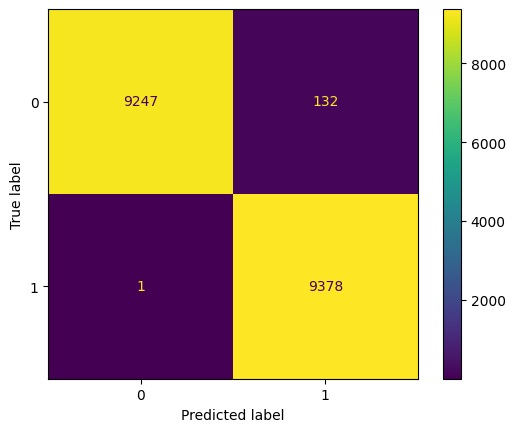

In [ ]:

X_cv = df_train.drop('label', axis=1)
y_cv = df_train['label']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
precisions_per_class = []
recalls_per_class = []
f1_scores_per_class = []
conf_matrices = []

for fold, (train_index, val_index) in enumerate(skf.split(X_cv, y_cv)):
    X_train_fold, X_val_fold = X_cv.iloc[train_index], X_cv.iloc[val_index]
    y_train_fold, y_val_fold = y_cv.iloc[train_index], y_cv.iloc[val_index]


    xgb_model_cv = XGBClassifier(
    n_estimators=100,
    scale_pos_weight= (y_train == 0).sum() / (y_train == 1).sum(),
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
    xgb_model_cv.fit(X_train_fold, y_train_fold)
    y_pred_val = xgb_model_cv.predict(X_val_fold)

    acc = accuracy_score(y_val_fold, y_pred_val)
    prec = precision_score(y_val_fold, y_pred_val, average=None, zero_division=0)
    rec = recall_score(y_val_fold, y_pred_val, average=None, zero_division=0)
    f1 = f1_score(y_val_fold, y_pred_val, average=None, zero_division=0)
    cm = confusion_matrix(y_val_fold, y_pred_val)

    accuracies.append(acc)
    precisions_per_class.append(prec)
    recalls_per_class.append(rec)
    f1_scores_per_class.append(f1)
    conf_matrices.append(cm)

precisions_per_class = np.array(precisions_per_class)
recalls_per_class = np.array(recalls_per_class)
f1_scores_per_class = np.array(f1_scores_per_class)

print(f"Acuratete medie pe validare: {np.mean(accuracies):.4f}")
print(f"Deviatie standard: {np.std(accuracies):.4f}")

for i, cls in enumerate([0, 1]):
    print(f"\n--- Clasa {cls} ---")
    print(f"Precizie medie: {np.mean(precisions_per_class[:, i]):.4f}")
    print(f"Recall mediu:    {np.mean(recalls_per_class[:, i]):.4f}")
    print(f"F1-score mediu:  {np.mean(f1_scores_per_class[:, i]):.4f}")

conf_matrix_avg = np.mean(conf_matrices, axis=0).astype(int)
print("\nMatricea de confuzie medie:")
print(conf_matrix_avg)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_avg).plot(cmap='viridis')
